In [14]:
import numpy as np
from sus.protocol_designer import System, Protocol, Potential, Compound_Protocol
from sus.protocol_designer.protocol import sequential_protocol
from IPython import display
from IPython.display import HTML
from quick_sim import setup_sim
from edward_tools.coupled_fq_potential import coupled_flux_qubit_pot, coupled_flux_qubit_force, coupled_fq_pot
import edward_tools.fq_runner as fq_runner
from edward_tools.visualization import animate_sim_flux_qubit

import kyle_tools as kt
import matplotlib.pyplot as plt

import importlib, os
from edward_tools import coupled_fq_protocol_library, cfq_runner
from PARAMETER_INPUT import *
from PARAMETER_INPUT import _lambda, _theta, _eta

from edward_tools import coupled_fq_protocol_library
import edward_tools.cfq_batch_sweep as cfq_batch_sweep
%load_ext jupyternotify

coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system
get_potential_shot_at_different_t = coupled_fq_protocol_library.get_potential_shot_at_different_t
get_potential_shot_at_different_t_1D = coupled_fq_protocol_library.get_potential_shot_at_different_t_1D
create_simple_protocol_parameter_dict = coupled_fq_protocol_library.create_simple_protocol_parameter_dict
create_system_from_storage_and_computation_protocol = coupled_fq_protocol_library.create_system_from_storage_and_computation_protocol
coupled_fq_runner = importlib.reload(cfq_runner)
coupled_fq_protocol_library = importlib.reload(coupled_fq_protocol_library)
create_system = coupled_fq_protocol_library.create_system


The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


# basic settings

In [15]:
"""
# step 0: modify parameters
- All the parameters are stored in a separate file PARAMETER_INPUT
- You can override some of the parameters here.
"""
params['N'] = 10_000
params['dt'] = 1.0/100

In [16]:
"""
# step 1: Define potential
"""
coupled_fq_default_param = [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, x_c0]
[phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound] = np.array([4, 4, 4, 4])/time_scale_factor

coupled_fq_domain = [[-phi_1_bound, -phi_2_bound, -phi_1dc_bound, -phi_2dc_bound], \
                     [phi_1_bound, phi_2_bound, phi_1dc_bound, phi_2dc_bound]]

coupled_fq_pot = Potential(coupled_flux_qubit_pot, coupled_flux_qubit_force, 14, 4,\
                           default_params = coupled_fq_default_param,  relevant_domain = coupled_fq_domain)

In [17]:
"""
# step 2: Define initial condition and protocol
"""
zeroDissipation = True
params['sim_params'] = [_lambda, _theta, _eta]
if zeroDissipation:
    params['sim_params'] = [_lambda * 0, _theta, _eta * 0]


manual_domain=[np.array([-5, -5]), np.array([5, 5])]
phi_1_dcx, phi_2_dcx = 0, 0
phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx

time_length_1 = 80
phi_1_dcx_off = 0; phi_2_dcx_off = 0; M_12_off = 0
phi_1_dcx_on = 3.0; phi_2_dcx_on = 3.0; M_12_on = -0.7

k_i = 20
k_f = 1
initial_parameter_dict = {
        "U0_1": U0_1,     "U0_2": U0_2,     "gamma_1": k_i,  "gamma_2": k_i,
        "beta_1": beta_1,   "beta_2": beta_2,   "d_beta_1": d_beta_1 ,   "d_beta_2": d_beta_2,
        "phi_1_x": 0,  "phi_2_x": 0,  "phi_1_dcx": phi_1_dcx_off,  "phi_2_dcx": phi_1_dcx_off,
        "M_12": M_12_off, 'x_c': x_c
}

In [18]:
protocol_list_options = [
    {"placeholder": ""},
    {"duration":2000, "gamma_1": k_f,  "name":"(1) mix in y direction"},
]

In [19]:
params['sim_params'] = [_lambda, _theta, _eta]
# params['sim_params'] = [_lambda * 0, _theta, _eta * 0]

protocol_list = [protocol_list_options[1]]
print(params['sim_params'])
print(initial_parameter_dict["gamma_1"])
for x in protocol_list:
    print(x)

[array([0.00269542, 0.00269542, 0.00269542, 0.00269542]), array([1., 4., 1., 4.]), array([0.01310394, 0.02620788, 0.01310394, 0.02620788])]
20
{'duration': 2000, 'gamma_1': 1, 'name': '(1) mix in y direction'}


In [20]:
"""
# First system
"""

t_array = np.linspace(0, 80, 100)
computation_protocol_parameter_dict = coupled_fq_protocol_library.customizedProtocol(initial_parameter_dict, \
                                                                    protocol_list)
storage_protocol, comp_protocol = create_system(computation_protocol_parameter_dict)





In [21]:
comp_protocol.protocol_array[0].interpolation = "linear"

In [22]:
p_array_sigmoid = [comp_protocol.protocol_array[0].get_params(t)[2] for t in t_array]

/Users/tkwtang/source/sus/protocol_designer/protocol.py:220: RuntimeWarning: invalid value encountered in divide
  lambda_t = init / (1 - t/total_time + np.sqrt(init / final) * (t/total_time))**2


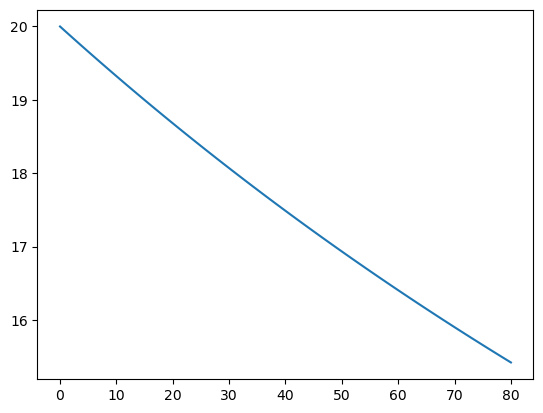

In [23]:
plt.plot(t_array, p_array_sigmoid)

# Computation protocol interpolation method investigation

# run simulation

In [24]:
cfqr = cfq_runner.coupledFluxQubitRunner(potential = coupled_fq_pot, params = params, \
                                                storage_protocol= storage_protocol, \
                                                computation_protocol= comp_protocol, percentage=1.0)
cfqr.has_velocity = False
cfqr.initialize_sim()
cfqr.set_sim_attributes()
init_state_saved = cfqr.init_state

generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 10007 samples out of 10000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 10000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 2000.0
from simulation.py: number of steps: 200000, dt: 0.01


In [ ]:
# step 5: perform simulations

simResult = cfq_batch_sweep.simulateSingleCoupledFluxQubit(params, initial_parameter_dict, protocol_list, \
                                        initial_state = None, manual_domain = manual_domain, \
                                        phi_1_dcx = phi_1_dcx,  phi_2_dcx = phi_2_dcx, \
                                        percentage = 1, \
                                        as_step = np.s_[::])


 initializing...
generating new initial_state
using a lower resolution for searching a space in >3 dimensions
new resolution is 50
 found 11020 samples out of 10000
from system: finish the while loop in sampling.
as step value: slice(None, None, None), sampleSize: 10000
slice(None, None, None)
from cfq_runner.py, The as_step is slice(None, None, None) and dt is 0.01
from quick_sim.py
gamma: [0.00269542 0.00269542 0.00269542 0.00269542], theta: [1. 4. 1. 4.] and eta: [0.01310394 0.02620788 0.01310394 0.02620788]
from quick_sim.py: system.protocol.t_i = 0.0, system.protocol.t_f = 2000.0
from simulation.py: number of steps: 200000, dt: 0.01

 running sim...
final_statestep 199999
all_state
work_done

 analyzing output...
For the states, 


# animations

In [ ]:
# # animations
# vmin, vmax = 0, 100
# frame_skip = 50
# # phi_1_dc, phi_2_dc = phi_1_dcx, phi_2_dcx
# all_state = simResult["cfqr"].sim.output.all_state['states']
# simResult["cfqr"].system.protocol_list = protocol_list
# time_range = (computation_protocol_parameter_dict["t"][0], computation_protocol_parameter_dict["t"][-1])

# ani,_,_ = animate_sim_flux_qubit(all_state, system = simResult["cfqr"].system ,
#                                    times = time_range, frame_skip=frame_skip, color_by_state=True,
#                                    vmin = vmin, vmax = vmax,
#                                    manual_domain = manual_domain)

In [ ]:
# from IPython import display
# video = ani.to_html5_video()
# html = display.HTML(video)
# display.display(html)

# work analysis

In [ ]:
step_time_array = np.cumsum(np.array([x["duration"] for x in protocol_list]))/params['dt']
name_array = [x["name"] for x in protocol_list]


plt.hist(simResult["work_distribution"], bins = 45)
plt.show()
jarzyn_term = np.mean(np.exp(-simResult["work_distribution"]))
cal_dF = -np.log(jarzyn_term)
analytic_dF = 1/2 * np.log(k_f/k_i)
print(f"mean work = {np.mean(simResult['work_distribution'])}")
print(f'jarzyn = {jarzyn_term}')
print(f'cal_∆F = {cal_dF}, analytic_df = {analytic_dF}')
print([x["duration"] for x in protocol_list])